# Pipeline Notebook for Base Models

## This Notebook Is creating the Pickle Files of the Base models at the End (uncalibrated)

### Contains Pipelines for Random Forrest, SVC and XGBoost Model


### Import the Libraries

In [1]:
import os
import sys
import pickle

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.svm import SVC

from xgboost import XGBClassifier

# import own modules
sys.path.append("..")  # Adds higher directory to python modules path.
from scripts import preprocessing as pp
from scripts import evaluate_models as em

plt.style.use(
    "https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle"
)

### Define our Parameters

In [2]:
# metric
ftwo_scorer = make_scorer(fbeta_score, beta=2)

# defaults
RSEED = 42
cv = 10
n_jobs = -1
verbose = 0

### Import the Dataframe with Custom Functions

Use this Code for Preprocessing!!! Otherwise the Models will have another Performance due to the Target Variable!

In [3]:
# path to csv file
path_df = os.path.join("..", "data", "df_deep_sam.csv")

# get features
df = pd.read_csv(path_df)

# set id as index
df = df.set_index("id", drop=True)

# drop first batch of useless variables
df = df.drop(columns=["img", "sp_idx"])
df = df.drop(columns=[col for col in df.columns if "_obj" in col])

# find numerical and categorical columns
num_cols = df.columns[df.dtypes != "object"]
cat_cols = df.columns[df.dtypes == "object"]

# print info
print(f" -> dataframe has {df.shape[0]} instances and {df.shape[1]} columns")
print(f" -> there are {len(num_cols)} numerical columns")
print(f" -> there are {len(cat_cols)} categoricals columns")

 -> dataframe has 7598 instances and 44 columns
 -> there are 44 numerical columns
 -> there are 0 categoricals columns


### This Line is Crucial for our Model Performance! We kick out Wrong Measurements with this

In [4]:
# processing
df = df[df["sp_fix_duration_ms_total"] <= 5000]

## Train Test Split - Use this for all Models!!! Pipelines do your Feature Selection
- We do the Train Test Split on the Whole Dataframe
- Each Pipeline will get the Features it needs from it
- So only 1 Split to run all Model on 

In [5]:
# prepare features and target
X = df.drop("asd", axis=1)
y = df["asd"]

# train-test-split
X_train, X_test, y_train, y_test = pp.split(X, y)

# print info
print(f"train-set has '{len(y_train)}' samples & '{X.shape[1]}' features")
print(f"test-set has '{len(y_test)}' samples - out of '{df.shape[0]}'")
print(f"  ~ {len(y_test) / df.shape[0] * 100:.2f}% of full dataset")

train-set has '6485' samples & '43' features
test-set has '732' samples - out of '7217'
  ~ 10.14% of full dataset


# Examining the Columns we need and produce Feature Lists for each Model

### Defining the Lists for the Features each Model uses


In [6]:
# 11 Features on Best SVC Model
svc_feature_list = [
    "sp_fix_duration_ms_total",
    "sp_fix_duration_ms_mean",
    "sp_fix_duration_ms_var",
    "sam_sal_first_fixation",
    "sam_sal_sum",
    "sam_sal_KLD",
    "obj_t_abs_on_background",
    "obj_t_abs_on_animate",
    "obj_n_fix_background",
    "obj_n_fix_inanimate",
    "obj_n_fix_animate",
]

# Features on Best XGB Model
xgb_feature_list = [
    "sp_fix_count",
    "sp_fix_duration_ms_var",
    "sp_len_px_total",
    "sp_saccade_amplitude_px_mean",
    "sp_saccade_amplitude_px_var",
    "sp_distance_to_centre_px_mean",
    "sp_distance_to_centre_px_var",
    "sp_distance_to_sp_mean_px_mean",
    "sp_distance_to_sp_mean_px_var",
    "dg_sal_first_fixation",
    "dg_sal_sum",
    "dg_sal_max",
    "dg_sal_weighted_duration_sum",
    "dg_sal_weighted_duration_mean",
    "dg_sal_KLD",
    "dg_sal_NSS",
    "obj_t_abs_on_face",
    "obj_t_rel_on_face",
    "obj_t_abs_on_animate",
    "obj_t_abs_on_inanimate",
    "obj_t_abs_on_background",
    "obj_t_rel_on_animate",
    "obj_t_rel_on_inanimate",
    "obj_t_rel_on_background",
]

# Best Features for Random Forrest Model
rf_feature_list = [
    "sp_fix_count",
    "sp_fix_duration_ms_total",
    "sp_fix_duration_ms_mean",
    "sp_fix_duration_ms_var",
    "sp_len_px_total",
    "sp_saccade_amplitude_px_mean",
    "sp_saccade_amplitude_px_var",
    "sp_distance_to_centre_px_mean",
    "sp_distance_to_centre_px_var",
    "sp_distance_to_sp_mean_px_mean",
    "sp_distance_to_sp_mean_px_var",
    "dg_sal_first_fixation",
    "dg_sal_mean",
    "dg_sal_sum",
    "dg_sal_max",
    "dg_sal_weighted_duration_sum",
    "dg_sal_weighted_duration_mean",
    "dg_sal_KLD",
    "dg_sal_NSS",
    "obj_t_abs_on_animate",
    "obj_t_abs_on_background",
]

# Transformers, Preproccessing and Pipeline for our 3 Base Models

### SVC Model

In [7]:
# Setting up a Transformer for SVC with my Custom Function and the Scaler
transformer_svc = [("scaler", StandardScaler(), svc_feature_list)]

# Wrap a ColumnTransformer around the transformer_svc
preprocessing_svc = ColumnTransformer(transformer_svc, remainder="drop")

# pack the preprocessing steps into a Pipeline
svc_pipeline = Pipeline(
    [
        ("preprocessor", preprocessing_svc),
        (
            "classifier",
            SVC(C=0.1, degree=4, kernel="poly", gamma="scale", probability=True),
        ),
    ]
)

### XGBoost Model

In [8]:
# Setting up a Transformer for SVC with my Custom Function and the Scaler
transformer_xgb = [("scaler", MinMaxScaler(), xgb_feature_list)]

# Wrap a ColumnTransformer around the transformer_svc
preprocessing_xgb = ColumnTransformer(transformer_xgb, remainder="drop")

# pack the preprocessing steps into a Pipeline
xgb_pipeline = Pipeline(
    [
        ("preprocessor", preprocessing_xgb),
        (
            "classifier",
            XGBClassifier(learning_rate=0.01, max_depth=5, n_estimators=100),
        ),
    ]
)

### Random Forrest Pipeline

In [9]:
# Define the transformer for Random Forest
transformer_rf = [
    (
        "feature_selector",
        "passthrough",
        rf_feature_list,
    )
]

# Wrap a ColumnTransformer around the transformer_rf
preprocessing_rf = ColumnTransformer(transformer_rf, remainder="drop")

# Create the Random Forest pipeline
rf_pipeline = Pipeline(
    [
        ("preprocessor", preprocessing_rf),
        (
            "classifier",
            RandomForestClassifier(
                max_depth=7,
                max_features="sqrt",
                min_samples_leaf=40,
                min_samples_split=50,
                n_estimators=50,
                random_state=RSEED,
                n_jobs=n_jobs,
                verbose=0,
            ),
        ),
    ]
)

## Quick Check for each Base Model if Pipeline gives the same Output

### SVC Model Pred + Analysis

In [10]:
# Fit the svc_pipeline on the training data
svc_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['sp_fix_duration_ms_total',
                                                   'sp_fix_duration_ms_mean',
                                                   'sp_fix_duration_ms_var',
                                                   'sam_sal_first_fixation',
                                                   'sam_sal_sum', 'sam_sal_KLD',
                                                   'obj_t_abs_on_background',
                                                   'obj_t_abs_on_animate',
                                                   'obj_n_fix_background',
                                                   'obj_n_fix_inanimate',
                                                   'obj_n_fix_animate'])])),
                ('classifier',
                 SVC(C=0.1, degree=4, kernel='poly', probability=True))])

In [11]:
# Predict on the test set
y_pred_train = svc_pipeline.predict(X_train)
y_proba_train = svc_pipeline.predict_proba(X_train)
y_pred_test = svc_pipeline.predict(X_test)
y_pred_proba_test = svc_pipeline.predict_proba(X_test)


#### Evaluate the SVC Model

-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.740     0.418     0.534      3252
           1      0.593     0.852     0.699      3233

    accuracy                          0.635      6485
   macro avg      0.666     0.635     0.617      6485
weighted avg      0.667     0.635     0.617      6485

f(0.5)-score: 0.631
f(2.0)-score: 0.784

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.774     0.453     0.571       371
           1      0.606     0.864     0.712       361

    accuracy                          0.656       732
   macro avg      0.690     0.659     0.642       732
weighted avg      0.691     0.656     0.641       732

f(0.5)-score: 0.644
f(2.0)-score: 0.796



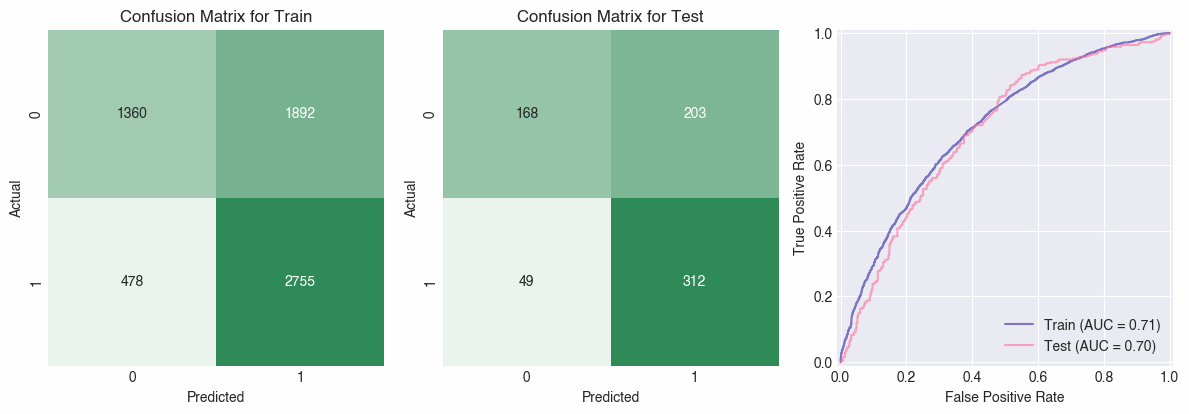

In [12]:
# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=y_pred_train,
    y_train_proba=y_proba_train,
    y_test=y_test,
    y_test_pred=y_pred_test,
    y_test_proba=y_pred_proba_test,
)

#### Safe the whole Pipeline as Pickle File

In [13]:
# Save the updated model to the same folder with the same filename
pickle_file_path = os.path.join("..", "models", "uncalibrated_pipelines", "SVC_uncalib.pickle")
with open(pickle_file_path, "wb") as f:
    pickle.dump(svc_pipeline, f)

### RF Model Pred + Analysis

In [14]:
# Fit the rf_pipeline on the training data
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('feature_selector',
                                                  'passthrough',
                                                  ['sp_fix_count',
                                                   'sp_fix_duration_ms_total',
                                                   'sp_fix_duration_ms_mean',
                                                   'sp_fix_duration_ms_var',
                                                   'sp_len_px_total',
                                                   'sp_saccade_amplitude_px_mean',
                                                   'sp_saccade_amplitude_px_var',
                                                   'sp_distance_to_centre_px_mean',
                                                   'sp_distance_to_centre_px_var',
                                                   'sp_distance_to_...
                                                   'sp_distance_to_sp_mean_px_var',
                                                   'dg_sal_first_fixation',
                                                   'dg_sal_mean', 'dg_sal_sum',
                                                   'dg_sal_max',
                                                   'dg_sal_weighted_duration_sum',
                                                   'dg_sal_weighted_duration_mean',
                                                   'dg_sal_KLD', 'dg_sal_NSS',
                                                   'obj_t_abs_on_animate',
                                                   'obj_t_abs_on_background'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=7, min_samples_leaf=40,
                                        min_samples_split=50, n_estimators=50,
                                        n_jobs=-1, random_state=42))])

In [15]:
# Predict on the test set
y_pred_train = rf_pipeline.predict(X_train)
y_proba_train = rf_pipeline.predict_proba(X_train)
y_pred_test = rf_pipeline.predict(X_test)
y_pred_proba_test = rf_pipeline.predict_proba(X_test)

### Evaluate RF Model

-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.713     0.713     0.713      3252
           1      0.711     0.712     0.712      3233

    accuracy                          0.712      6485
   macro avg      0.712     0.712     0.712      6485
weighted avg      0.712     0.712     0.712      6485

f(0.5)-score: 0.711
f(2.0)-score: 0.712

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.705     0.741     0.723       371
           1      0.719     0.681     0.700       361

    accuracy                          0.712       732
   macro avg      0.712     0.711     0.711       732
weighted avg      0.712     0.712     0.711       732

f(0.5)-score: 0.711
f(2.0)-score: 0.689



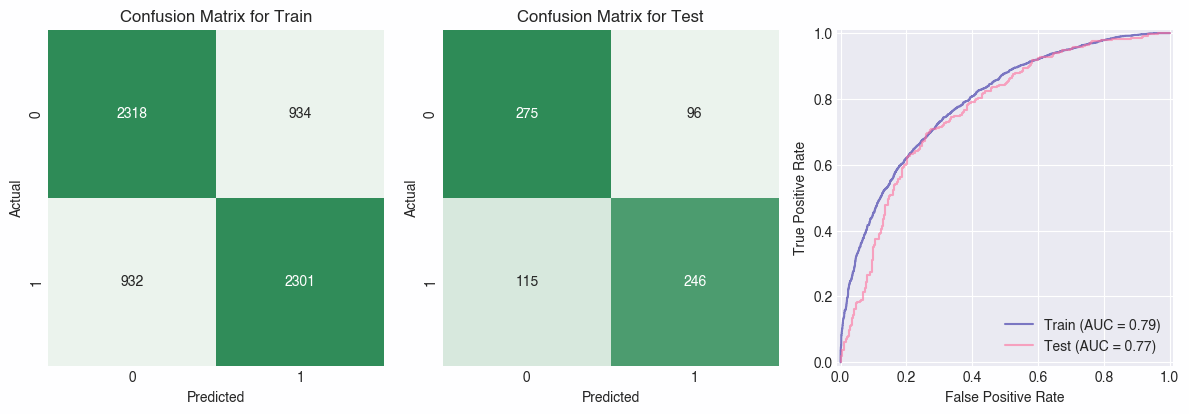

In [16]:
# evaluate model with own build function in features.py
em.report(
    y_train=y_train,
    y_train_pred=y_pred_train,
    y_train_proba=y_proba_train,
    y_test=y_test,
    y_test_pred=y_pred_test,
    y_test_proba=y_pred_proba_test,
)

### Safe the RF Base Model Pickle

In [17]:
# Save the RF model back to the same pickle file
pickle_file_path = os.path.join("..", "models", "uncalibrated_pipelines", "RF_uncalib.pickle")
with open(pickle_file_path, "wb") as f:
    pickle.dump(rf_pipeline, f)

### XGBoost Model Pred + Analysis

In [18]:
# xgb Pipeline Test
xgb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                                  ['sp_fix_count',
                                                   'sp_fix_duration_ms_var',
                                                   'sp_len_px_total',
                                                   'sp_saccade_amplitude_px_mean',
                                                   'sp_saccade_amplitude_px_var',
                                                   'sp_distance_to_centre_px_mean',
                                                   'sp_distance_to_centre_px_var',
                                                   'sp_distance_to_sp_mean_px_mean',
                                                   'sp_distance_to_sp_mean_px_var',
                                                   'dg_sal_first...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [19]:
# Predict on the test set
y_pred_train = xgb_pipeline.predict(X_train)
y_proba_train = xgb_pipeline.predict_proba(X_train)
y_pred_test = xgb_pipeline.predict(X_test)
y_pred_proba_test = xgb_pipeline.predict_proba(X_test)

-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.734     0.715     0.724      3252
           1      0.720     0.739     0.729      3233

    accuracy                          0.727      6485
   macro avg      0.727     0.727     0.727      6485
weighted avg      0.727     0.727     0.727      6485

f(0.5)-score: 0.724
f(2.0)-score: 0.735

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.698     0.709     0.703       371
           1      0.696     0.684     0.690       361

    accuracy                          0.697       732
   macro avg      0.697     0.697     0.697       732
weighted avg      0.697     0.697     0.697       732

f(0.5)-score: 0.693
f(2.0)-score: 0.686



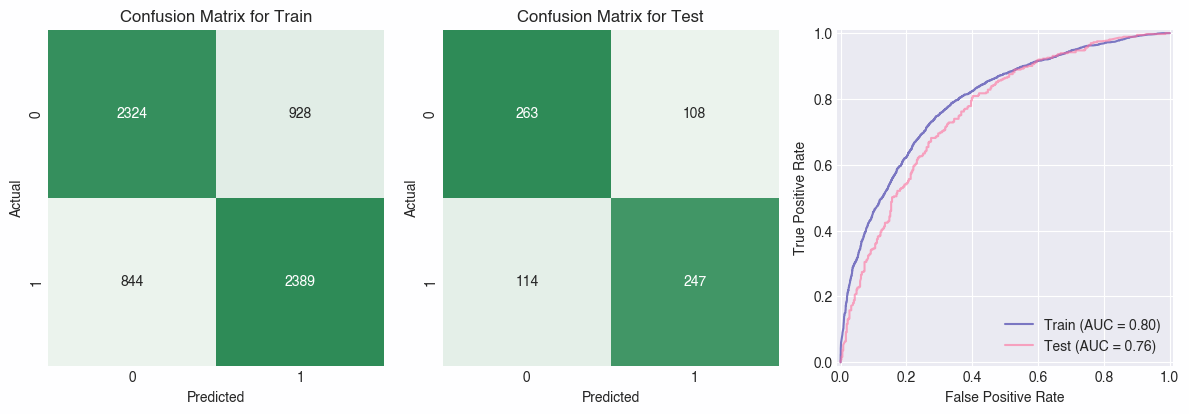

In [20]:
# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=y_pred_train,
    y_train_proba=y_proba_train,
    y_test=y_test,
    y_test_pred=y_pred_test,
    y_test_proba=y_pred_proba_test,
)

### Safe the XGB Pipeline as well

In [21]:
# Save the XGBoost model back to the same pickle file
pickle_file_path = os.path.join("..", "models", "uncalibrated_pipelines", "XGB_uncalib.pickle")
with open(pickle_file_path, "wb") as f:
    pickle.dump(xgb_pipeline, f)